# Outlining some pre-processing

In [1]:
%load_ext jupyter_black
import os
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [2]:
# gis_dir = Path(os.getenv("STORM_DATA_DIR")) / "gis files/"
input_dir = (
    Path(os.getenv("STORM_DATA_DIR"))
    / "analysis/02_new_model_input/02_housing_damage/input/"
)
output_dir = (
    Path(os.getenv("STORM_DATA_DIR"))
    / "analysis/02_new_model_input/02_housing_damage/output/"
)
adm3_shp = gpd.read_file(input_dir / "phl_adminboundaries_candidate_adm3.zip")

In [3]:
phl_north_bld = gpd.read_file(
    input_dir / "hotosm_phl_north_buildings_polygons_shp.zip"
)
phl_south_bld = gpd.read_file(
    input_dir / "hotosm_phl_south_buildings_polygons_shp.zip"
)

In [4]:
phl_bld = pd.concat([phl_north_bld, phl_south_bld])

<AxesSubplot: >

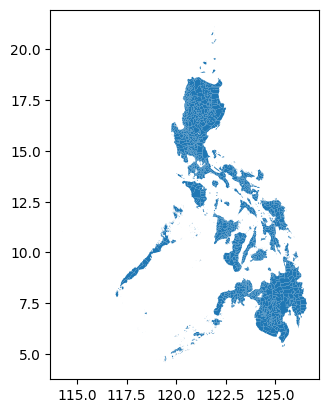

In [5]:
adm3_shp.loc[:, "geometry"].plot()

## Creation of grid

In [6]:
# grid creation
xmin, xmax, ymin, ymax = 114.25, 126.75, 4.55, 21.15

cell_size = 0.1

cols = list(np.arange(xmin, xmax + cell_size, cell_size))
rows = list(np.arange(ymin, ymax + cell_size, cell_size))
rows.reverse()
# using list comprehension instead of loop
polygons = [
    Polygon(
        [
            (x, y),
            (x + cell_size, y),
            (x + cell_size, y - cell_size),
            (x, y - cell_size),
        ]
    )
    for x in cols
    for y in rows
]
grid = gpd.GeoDataFrame({"geometry": polygons}, crs=adm3_shp.crs)
grid["id"] = grid.index + 1
# grid.to_crs(epsg=4326, inplace=True)
grid.head()

,geometry,id
0,"POLYGON ((114.25000 21.15000, 114.35000 21.150...",1
1,"POLYGON ((114.25000 21.05000, 114.35000 21.050...",2
2,"POLYGON ((114.25000 20.95000, 114.35000 20.950...",3
3,"POLYGON ((114.25000 20.85000, 114.35000 20.850...",4
4,"POLYGON ((114.25000 20.75000, 114.35000 20.750...",5


<AxesSubplot: >

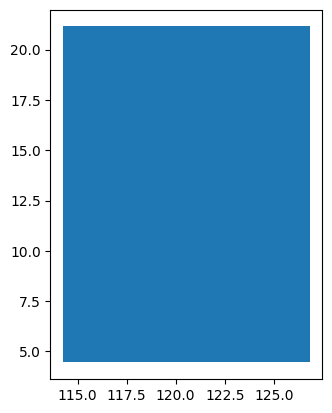

In [7]:
grid.loc[:, "geometry"].plot()

In [ ]:
# write as geopackage
grid.to_file(output_dir / "phl_0.1_degree_grid.gpkg", driver="GPKG")

## Creation of centroids

In [12]:
# creating centroids
# Grid
# Extract lat and lon from the centerpoint
grid["Longitude"] = grid["geometry"].centroid.map(lambda p: p.x)
grid["Latitude"] = grid["geometry"].centroid.map(lambda p: p.y)
grid["Centroid"] = (
    round(grid["Longitude"], 2).astype(str)
    + "E"
    + "_"
    + +round(grid["Latitude"], 2).astype(str)
    + "N"
)
grid.head(5)

C:\Users\pauni\AppData\Local\Temp\ipykernel_18336\2061595231.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["Longitude"] = grid["geometry"].centroid.map(lambda p: p.x)
C:\Users\pauni\AppData\Local\Temp\ipykernel_18336\2061595231.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["Latitude"] = grid["geometry"].centroid.map(lambda p: p.y)


,geometry,id,Longitude,Latitude,Centroid
0,"POLYGON ((114.25000 21.15000, 114.35000 21.150...",1,114.30000,21.10000,114.3E_21.1N
1,"POLYGON ((114.25000 21.05000, 114.35000 21.050...",2,114.30000,21.00000,114.3E_21.0N
2,"POLYGON ((114.25000 20.95000, 114.35000 20.950...",3,114.30000,20.90000,114.3E_20.9N
3,"POLYGON ((114.25000 20.85000, 114.35000 20.850...",4,114.30000,20.80000,114.3E_20.8N
4,"POLYGON ((114.25000 20.75000, 114.35000 20.750...",5,114.30000,20.70000,114.3E_20.7N


C:\Users\pauni\AppData\Local\Temp\ipykernel_18336\710311070.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids["geometry"] = grid_centroids["geometry"].centroid


<AxesSubplot: >

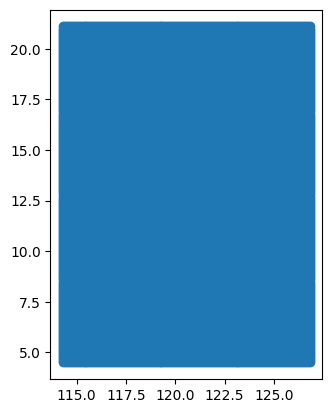

In [13]:
# Centroids
grid_centroids = grid.copy()
grid_centroids["geometry"] = grid_centroids["geometry"].centroid
grid_centroids.loc[:, "geometry"].plot()

In [ ]:
# write as geopackage
grid_centroids.to_file(
    output_dir / "phl_0.1_degree_grid_centroids.gpkg", driver="GPKG"
)

In [14]:
# building centroids
phl_bld_centroids = phl_bld.copy()
phl_bld_centroids["geometry"] = phl_bld_centroids["geometry"].centroid

C:\Users\pauni\AppData\Local\Temp\ipykernel_18336\1346171841.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  phl_bld_centroids["geometry"] = phl_bld_centroids["geometry"].centroid


In [ ]:
phl_bld_centroids.to_file(input_dir / "phl_bld_centroids.gpkg", driver="GPKG")

## Intersection of grid and admin shapefile

(124.0, 126.0, 10.0, 11.0)

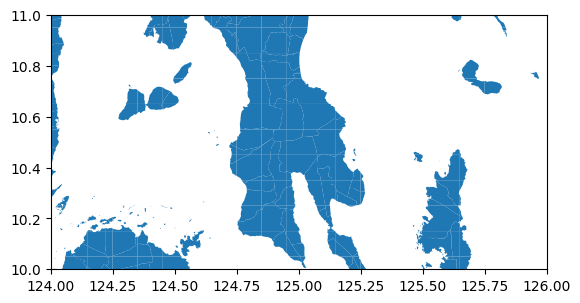

In [15]:
# intersection of grid and shapefile
adm3_grid_intersection = gpd.overlay(adm3_shp, grid, how="identity")
# adm3_grid_intersection = gpd.sjoin(adm3_shp, grid)
adm3_grid_intersection.loc[:, "geometry"].plot()
plt.axis([124, 126, 10, 11])

In [16]:
adm3_grid_intersection = adm3_grid_intersection.dropna(subset=["id"])

In [ ]:

adm3_grid_intersection.to_file(
    input_dir / "phl_adm3_grid_intersection.gpkg", driver="GPKG"
)

### For only grids that overlap with land

In [17]:
grid_land_overlap = grid.loc[grid["id"].isin(adm3_grid_intersection["id"])]

In [ ]:
grid_land_overlap.to_file(
    output_dir / "phl_0.1_degree_grid_land_overlap.gpkg", driver="GPKG"
)

In [18]:
grid_land_overlap_centroids = grid_centroids.loc[
    grid["id"].isin(adm3_grid_intersection["id"])
]

In [ ]:
grid_land_overlap_centroids.to_file(
    output_dir / "phl_0.1_degree_grid_centroids_land_overlap.gpkg",
    driver="GPKG",
)

## Area Computation

In [19]:
# computing areas
adm3_shp_area = adm3_shp.copy()
adm3_shp_area = adm3_shp_area.to_crs({"proj": "cea"})
adm3_shp_area["Area"] = adm3_shp_area["geometry"].area
adm3_shp_area["Area"].describe()

count         1647.00000
mean     178203548.62475
std      205850893.13715
min         399814.39589
25%       59475704.69187
50%      112122826.18895
75%      217178925.81056
max     2341425972.12693
Name: Area, dtype: float64

In [ ]:
adm3_shp_area.to_csv(input_dir / "adm3_area.csv")

In [20]:
grid_area = grid.copy()
grid_area = grid_area.to_crs({"proj": "cea"})
grid_area["Area_2"] = grid_area["geometry"].area
grid_area["Area_2"].describe()

count       21042.00000
mean    119695120.29336
std       2264611.78639
min     115037429.58114
25%     117847062.92781
50%     120110742.24897
75%     121743165.74512
max     122721372.36749
Name: Area_2, dtype: float64

In [21]:
adm3_grid_intersection_area = adm3_grid_intersection.copy()
adm3_grid_intersection_area = adm3_grid_intersection_area.to_crs(
    {"proj": "cea"}
)
adm3_grid_intersection_area["Area_3"] = adm3_grid_intersection_area[
    "geometry"
].area
adm3_grid_intersection_area["Area_3"].describe()

count        9887.00000
mean     29685571.41553
std      32217834.66106
min             0.00000
25%       3976912.50393
50%      17316476.08919
75%      45865982.27149
max     122477314.28712
Name: Area_3, dtype: float64

In [22]:
# merge
phl_adm3_grid_intersections_area = adm3_shp_area.merge(
    grid_area.merge(
        adm3_grid_intersection_area, on="id", suffixes=(None, "_3")
    ),
    on="ADM3_PCODE",
    suffixes=(None, "_2"),
)

phl_adm3_grid_intersections_area.drop(
    phl_adm3_grid_intersections_area.filter(regex="geometry").columns,
    axis=1,
    inplace=True,
)

In [ ]:
phl_adm3_grid_intersections_area.to_csv(
    input_dir / "phl_adm3_grid_intersections_area.csv"
)

## Building Count

### Assigning Buildings to Grids

In [23]:
phl_bld_centroids["random_id"] = phl_bld_centroids.reset_index().index + 1

In [24]:
phl_bld_centroid_grid_count = (
    grid_land_overlap.sjoin(phl_bld_centroids, how="left")
    .groupby(["id", "Centroid"])
    .count()
    .rename(columns={"random_id": "numbuildings"})
    .reset_index()[["id", "Centroid", "numbuildings"]]
)

In [26]:
phl_bld_centroid_grid_count.to_csv(
    input_dir / "phl_hotosm_bld_centroid_grid_count.csv"
)

In [25]:
phl_bld_centroid_grid_count.head(8)

,id,Centroid,numbuildings
0,101,114.3E_11.1N,0
1,4475,116.9E_7.9N,0
2,4639,117.0E_8.2N,0
3,4640,117.0E_8.1N,3
4,4641,117.0E_8.0N,124
5,4642,117.0E_7.9N,91
6,4643,117.0E_7.8N,37
7,4805,117.1E_8.3N,0


In [27]:
# this number if slightly higher than the municipality count 
# there are some buildings in the ocean and are in grids
# not municipalities which should be fixed.
phl_bld_centroid_grid_count["numbuildings"].sum()

10338272

### Testing new way of counting buildings

In [28]:
# assigning buildings to municipalities
phl_bld_centroid_municip_count = (
    adm3_shp.sjoin(phl_bld_centroids, how="left")
    .groupby("ADM3_PCODE")
    .count()
    .rename(columns={"random_id": "numbuildings"})
    .reset_index()[["ADM3_PCODE", "numbuildings"]]
)

In [29]:
phl_bld_centroid_municip_count["numbuildings"].sum()

10324006

In [30]:
phl_bld_centroid_municip_count[
    phl_bld_centroid_municip_count["ADM3_PCODE"] == "PH157005000"
]

,ADM3_PCODE,numbuildings
1494,PH157005000,0


In [32]:
phl_bld_centroid_municip_count.to_csv(
    input_dir / "phl_hotosm_bld_centroid_municip_count.csv"
)

In [31]:
phl_bld_centroid_municip_count["numbuildings"].sum()
len(phl_bld_centroid_municip_count["ADM3_PCODE"].unique())

1647

In [33]:
# assigning buildings to intersections
phl_bld_centroid_municip_intersection_count = (
    adm3_grid_intersection.sjoin(phl_bld_centroids, how="left")
    .groupby(["ADM3_PCODE", "id", "Centroid"])
    .count()
    .rename(columns={"random_id": "numbuildings"})
    .reset_index()[["ADM3_PCODE", "id", "Centroid", "numbuildings"]]
)

In [34]:
phl_bld_centroid_municip_intersection_count[
    phl_bld_centroid_municip_intersection_count["ADM3_PCODE"] == "PH157005000"
]

,ADM3_PCODE,id,Centroid,numbuildings
8530,PH157005000,8014.00000,119.0E_4.7N,0
8531,PH157005000,8181.00000,119.1E_4.7N,0
8532,PH157005000,8348.00000,119.2E_4.7N,0
8533,PH157005000,8680.00000,119.4E_4.9N,0
8534,PH157005000,8681.00000,119.4E_4.8N,0
8535,PH157005000,8682.00000,119.4E_4.7N,0
8536,PH157005000,8683.00000,119.4E_4.6N,0


In [35]:
phl_bld_centroid_municip_intersection_count.to_csv(
    input_dir / "phl_hotosm_bld_centroid_municip_intersection_count.csv"
)

In [36]:
phl_bld_centroid_municip_intersection_count.shape
len(phl_bld_centroid_municip_intersection_count["ADM3_PCODE"].unique())

1647

In [37]:
phl_bld_centroid_municip_intersection_count["numbuildings"].sum()

10324006

In [38]:
phl_bld_weight_matrix = phl_bld_centroid_municip_count.merge(
    phl_bld_centroid_municip_intersection_count,
    on="ADM3_PCODE",
    suffixes=(None, "_y"),
)
phl_bld_weight_matrix["weight"] = np.where(
    phl_bld_weight_matrix["numbuildings_y"] == 0,
    0,
    phl_bld_weight_matrix["numbuildings_y"]
    / phl_bld_weight_matrix["numbuildings"],
)

In [39]:
phl_bld_weight_matrix["weight"].describe()

count   9887.00000
mean       0.16598
std        0.24905
min        0.00000
25%        0.00036
50%        0.04117
75%        0.22206
max        1.00000
Name: weight, dtype: float64

In [41]:
phl_bld_weight_matrix[["ADM3_PCODE", "id", "Centroid", "weight"]].to_csv(
    input_dir / "phl_bld_weight_matrix.csv"
)